# Predicting and Classifying Musical Emotion in Spotify

### Samuel Veliveli, Lucas Lisman, Lexi Van Metre

### Problem Statement/Motivation

- Sentiment Analysis is a growing area of interest in the field of machine learning
- By quantifying  a user’s perceived emotions, greater analysis can be conducted to improve user experience, while also enhancing the service provided.
- We wanted to see if we could apply this to the field of spotify
    - Tailoring songs to moods can increase User Engagement
    - Increased User Engagement leads to more profit for the company
    - Positive feedback loop of better service and engagement, and profit. 



### Data Driven Question

“Can we predict a song's perceived emotion and use that predictive model to recommend a song based on a user’s mood with regards to their preferred genre on spotify?”



### Data Overview

- Dataset containing information on 114K songs found on Spotify
- Variables include the artist, album, and a variety of different measures (danceability, energy, popularity, speechiness etc) 
- Updated 7 months ago


### What is Valence?

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- Data was scraped using the spotify API

Developer’s answer: This is an attribute that we compute based on a wide variety of inputs. Generally speaking, we use a set of agreed upon ideas of what happy or positive music sounds like.
- This was originally developed at The Echo Nest.


### Data Exploration + Model

##### Model:  
Predictive + Classifying algorithm within each genre on whether the song is happy or sad and output recommendation

FIX!!
 - Turn valence into categorical
0.67-1 - Happy
0.4-0.66 - Neutral
0.0-0.33 - Sad

Genres Analyzed - Pop, Country, Hip-Hop, Disney, Blues



### Why Random Forest

XXXXXXX

In [133]:
# step 1: import the libraries and upload the dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder

import os

os.chdir("/Users/lucaslisman/Desktop/DS 3001/")
import seaborn as sns

In [2]:
# open the dataset.csv file 
music = pd.read_csv('dataset.csv')
# inspect the types of each column
music.dtypes

Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [3]:
# Subset for Genres
music = music[(music['track_genre'] == 'blues') |  (music['track_genre'] == 'country') | (music['track_genre'] == 'disney') | (music['track_genre'] == 'hip-hop') | (music['track_genre'] == 'pop')]

In [4]:
# check how many nas 
music.isna().sum()
# not too many nas, so we can drop them 
music = music.dropna()

### Correlation

/var/folders/gz/7h0l2_4j6fld7vp7x2k94bhr0000gn/T/ipykernel_2878/1839887761.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =music.corr()


<Axes: >

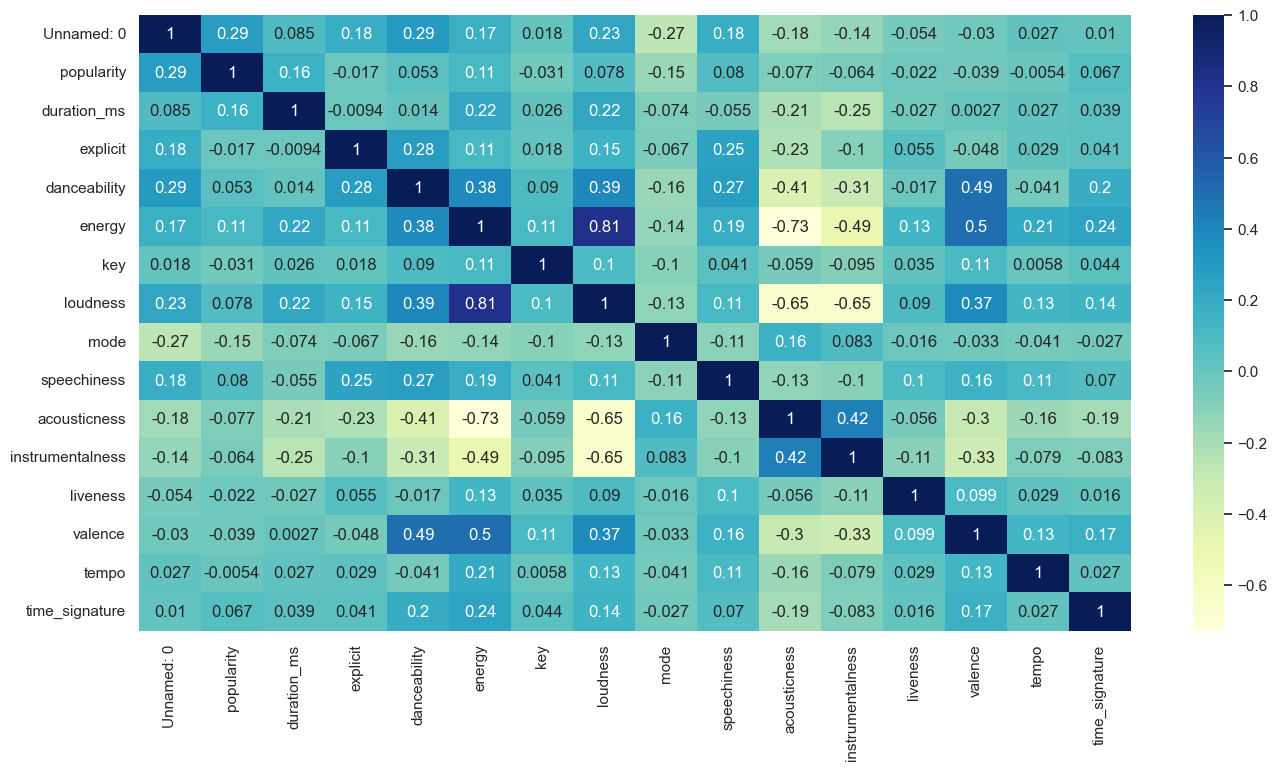

In [5]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr =music.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")

### Distribution of the Target Variable (Valence)

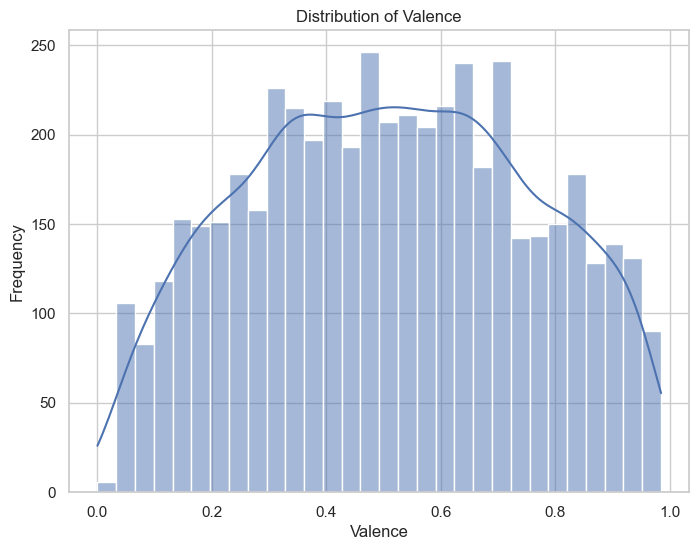

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(music["valence"], bins=30, kde=True)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Frequency")
plt.show()

### Numeric Feature Distribution

                                 Numeric Features Distribution                                  


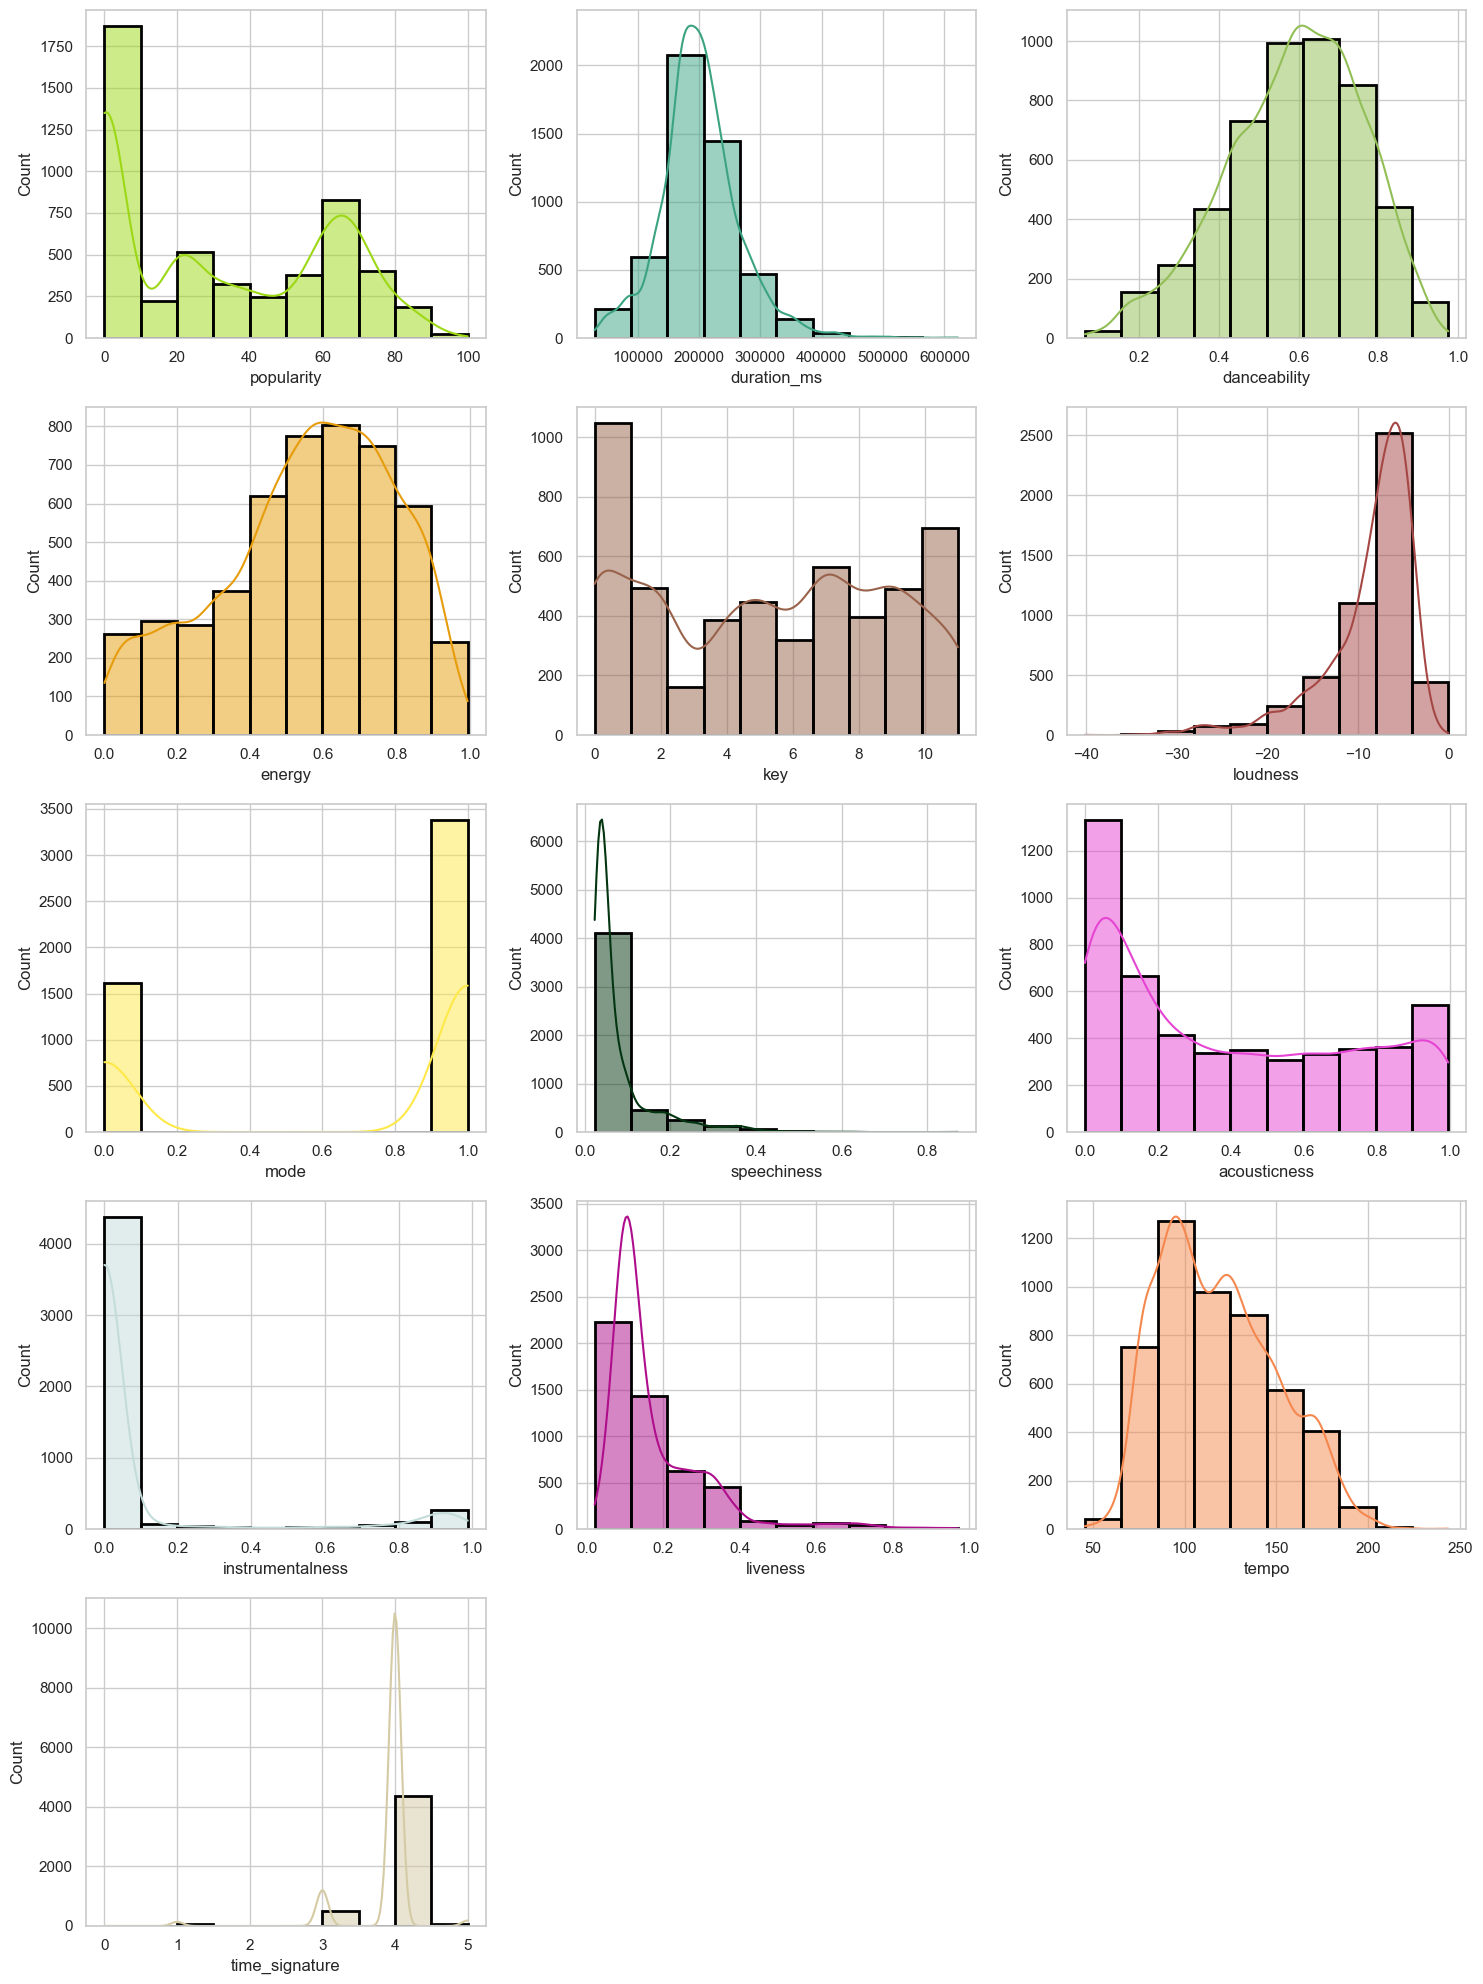

In [7]:
import math


target_column = 'valence'
numerical_features = music.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop(target_column)
# drop unnamed column
numerical_features = numerical_features.drop('Unnamed: 0')


print('\033[1mNumeric Features Distribution'.center(100))

# Define number of subplots per row
subplots_per_row = 3
num_rows = math.ceil(len(numerical_features) / subplots_per_row)

plt.figure(figsize=[15, 4 * num_rows])

for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, subplots_per_row, i + 1)
    sns.histplot(
        music[feature],
        kde=True,  # Add a kernel density estimate
        color=list(np.random.randint([255, 255, 255]) / 255),
        edgecolor="black", 
        linewidth=2,
        bins=10
    )

plt.tight_layout()
plt.show()


In [8]:
# lets fix some of the columns values --> example some of the track names are not legible
# lets remove the ones that are not in english, with any letters that contain special symbols 
# in another language other than english 
music = music[music['track_name'].str.contains('^[a-zA-Z ]+$')]
music['track_name'].value_counts()
# lets drop track_id because it is just a bunch of letters 
music = music.drop(['track_id'], axis = 1)
# also remove the unnamed column
music = music.drop(['Unnamed: 0'], axis = 1)
# lets also drop album name because this wont really contribute to valence 
music = music.drop(['album_name'], axis = 1)
# lets also drop artists since we dont have any tell about the artists fame 
music = music.drop(['artists'], axis = 1)
# lets also drop explicit because this won't really contribute to valence
music = music.drop(['track_name'], axis = 1)
# we want to be able to predict valence of the track, so maybe we can add this in later 


In [9]:
# View Dataset
music.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
8000,77,230613,False,0.509,0.448,4,-7.552,0,0.0357,0.00713,0.0137,0.2440,0.221,156.909,3,blues
8001,79,208760,False,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.273,113.980,4,blues
8003,84,232106,False,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.278,123.596,4,blues
8004,76,225026,False,0.572,0.214,7,-15.625,1,0.0293,0.64900,0.1290,0.1250,0.485,95.542,4,blues
8006,1,268040,False,0.270,0.577,0,-8.195,1,0.0573,0.75500,0.1230,0.1390,0.362,170.254,4,blues


In [10]:
#Subset by Genre
blues = music[music["track_genre"] == "blues"]
country = music[music["track_genre"] == "country"]
disney = music[music["track_genre"] == "disney"]
hiphop = music[music["track_genre"] == "hip-hop"]
pop = music[music["track_genre"] == "pop"]

In [11]:
blues = blues.drop(['track_genre'], axis = 1)
country = country.drop(['track_genre'], axis = 1)
disney = disney.drop(['track_genre'], axis = 1)
hiphop = hiphop.drop(['track_genre'], axis = 1)
pop = pop.drop(['track_genre'], axis = 1)

In [12]:
#View blues genre
blues.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
8000,77,230613,False,0.509,0.448,4,-7.552,0,0.0357,0.00713,0.0137,0.2440,0.221,156.909,3
8001,79,208760,False,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.273,113.980,4
8003,84,232106,False,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.278,123.596,4
8004,76,225026,False,0.572,0.214,7,-15.625,1,0.0293,0.64900,0.1290,0.1250,0.485,95.542,4
8006,1,268040,False,0.270,0.577,0,-8.195,1,0.0573,0.75500,0.1230,0.1390,0.362,170.254,4


In [13]:
#View country genre
country.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
19001,0,236455,False,0.520,0.751,5,-5.064,1,0.0551,0.171,0.000007,0.0624,0.519,156.044,4
19002,1,228320,False,0.590,0.389,2,-9.245,1,0.0387,0.411,0.000001,0.1170,0.389,166.055,4
19003,3,228013,False,0.369,0.192,4,-12.151,0,0.0400,0.555,0.000008,0.0954,0.148,175.212,3
19004,4,228013,False,0.369,0.192,4,-12.151,0,0.0400,0.555,0.000008,0.0954,0.148,175.212,3
19005,4,228013,False,0.369,0.192,4,-12.151,0,0.0400,0.555,0.000008,0.0954,0.148,175.212,3


In [14]:
#View disney genre
disney.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
26000,58,251520,False,0.530,0.584,0,-11.891,1,0.2180,0.2740,0.000000,0.158,0.575,81.854,4
26002,70,195493,False,0.274,0.144,5,-14.516,1,0.0482,0.9200,0.000388,0.290,0.302,61.551,5
26005,52,140160,False,0.270,0.623,4,-9.841,1,0.0930,0.0972,0.349000,0.267,0.463,157.240,3
26006,56,165533,False,0.460,0.574,4,-7.414,0,0.1120,0.3180,0.000000,0.100,0.370,67.697,4
26008,60,84720,False,0.686,0.379,5,-15.243,1,0.2230,0.8560,0.000000,0.103,0.923,137.953,4


In [15]:
#View hiphop genre
hiphop.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
51000,83,177391,False,0.860,0.541,1,-6.510,0,0.0325,0.16500,0.163000,0.0663,0.952,114.984,4
51001,83,170387,False,0.768,0.487,4,-8.936,0,0.0431,0.24000,0.000000,0.1750,0.722,137.034,4
51002,82,148188,False,0.711,0.702,5,-10.048,1,0.2330,0.00487,0.016300,0.0932,0.674,180.219,4
51003,77,206060,False,0.796,0.572,8,-7.030,0,0.0545,0.41600,0.000025,0.0975,0.304,98.967,4
51005,75,131077,False,0.847,0.558,8,-5.855,0,0.0663,0.32500,0.000000,0.1350,0.495,98.062,4


In [16]:
#View pop genre
pop.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
81000,91,200040,False,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4
81001,74,200120,False,0.535,0.765,1,-7.862,0,0.0444,0.05400,0.000000,0.0921,0.373,191.827,4
81002,83,177391,False,0.860,0.541,1,-6.510,0,0.0325,0.16500,0.163000,0.0663,0.952,114.984,4
81003,96,184613,True,0.733,0.690,9,-5.529,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4
81004,90,230453,True,0.679,0.587,7,-7.015,1,0.2760,0.14100,0.000006,0.1370,0.486,186.003,4


## Blues Model Building (+)

In [17]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = blues['valence']
X = blues.drop(['valence'], axis = 1)

In [18]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either happy or not happy 
# the cutoff is 0-0.7 and then 0.7-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changeBH(valence):
    if valence >= 0.7:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changeBH)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [20]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    301
1    182
Name: valence, dtype: int64
0    129
1     78
Name: valence, dtype: int64


In [21]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [22]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.7

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

bluesH_RF= RFC.fit(X_train,y_train)

# finished in 2.2 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


In [23]:
print('OOB error rate: ' + str(1-bluesH_RF.oob_score_))

OOB error rate: 0.20703933747412007


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.0731
True Positive Rate: 0.7857
Precision: 0.8667
Accuracy: 0.8737


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


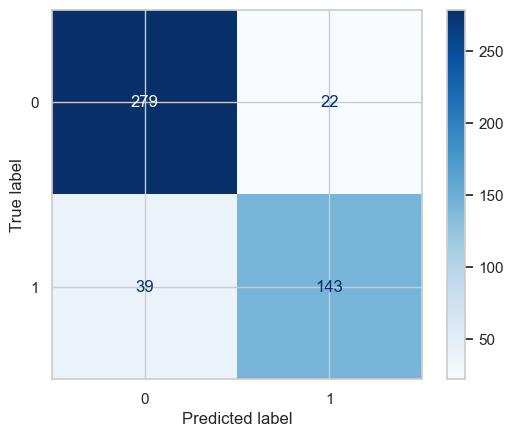

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions on the training set
y_pred_train = bluesH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bluesH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {bluesH_RF.score(X_train, y_train):.4f}")


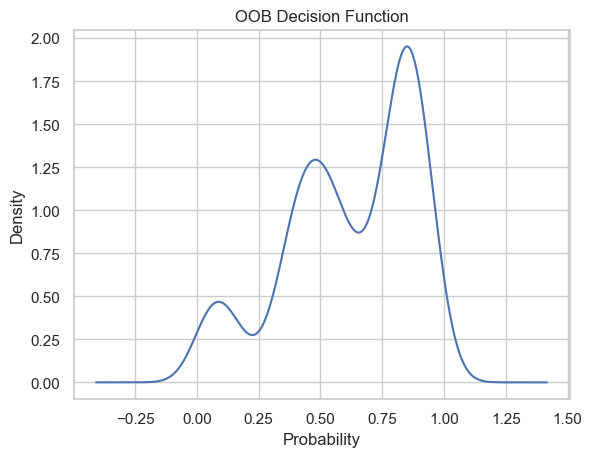

In [25]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.70
xx = pd.DataFrame(bluesH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [26]:
#determining feature importance

np.argmax(bluesH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(bluesH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.318610
duration_ms         0.129650
energy              0.102637
speechiness         0.071929
popularity          0.060501
acousticness        0.059131
liveness            0.054341
loudness            0.053982
tempo               0.053240
key                 0.047278
instrumentalness    0.037125
mode                0.007172
time_signature      0.004404
explicit            0.000000


In [27]:
bluesHOOB = 1-bluesH_RF.oob_score_
bluesHFPR = fpr
bluesHtpr = tpr
bluesHpre = precision
bluesA = bluesH_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


## Blues Model Building (-)

In [29]:
# lets separate our X and Y variables for our random forest 
# we will use the valence as our target variable
y = blues['valence']
X = blues.drop(['valence'], axis = 1)

In [30]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either sad or not sad 
# the cutoff is 0-0.3 and then 0.3-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changeBS(valence):
    if valence <= 0.3:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changeBS)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [32]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    425
1     58
Name: valence, dtype: int64
0    182
1     25
Name: valence, dtype: int64


In [33]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [34]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

bluesS_RF= RFC.fit(X_train,y_train)

# finished in 1.7 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


In [35]:
print('OOB error rate: ' + str(1-bluesS_RF.oob_score_))

OOB error rate: 0.10973084886128359


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.0000
True Positive Rate: 0.1034
Precision: 1.0000
Accuracy: 0.8923


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


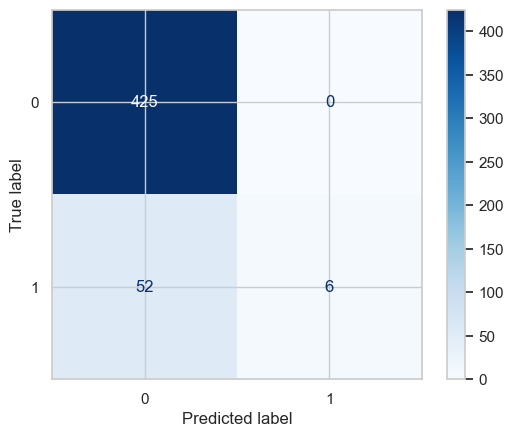

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions on the training set
y_pred_train = bluesS_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bluesH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {bluesS_RF.score(X_train, y_train):.4f}")

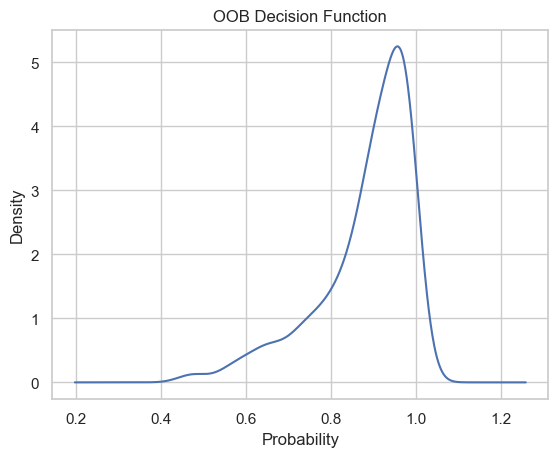

In [37]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.30
xx = pd.DataFrame(bluesS_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [38]:
#determining feature importance

np.argmax(bluesS_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(bluesS_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.284625
energy              0.159338
speechiness         0.100264
acousticness        0.082713
instrumentalness    0.061052
duration_ms         0.058340
loudness            0.057233
tempo               0.046118
liveness            0.039339
popularity          0.037854
time_signature      0.037096
key                 0.027668
mode                0.008359
explicit            0.000000


In [39]:
bluesSOOB = 1-bluesS_RF.oob_score_
bluesSFPR = fpr
bluesStpr = tpr
bluesSpre = precision
bluesSA = bluesS_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


## Country Model (+)

In [40]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = country['valence']
X = country.drop(['valence'], axis = 1)

In [41]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either happy or not happy 
# the cutoff is 0-0.7 and then 0.7-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changeCH(valence):
    if valence >= 0.7:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changeCH)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [43]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    384
1    127
Name: valence, dtype: int64
0    165
1     55
Name: valence, dtype: int64


In [44]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [45]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

cH_RF= RFC.fit(X_train,y_train)

# finished in 2.1 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


In [46]:
print('OOB error rate: ' + str(1-cH_RF.oob_score_))

OOB error rate: 0.20156555772994134


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.0156
True Positive Rate: 0.3937
Precision: 0.8929
Accuracy: 0.8376


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


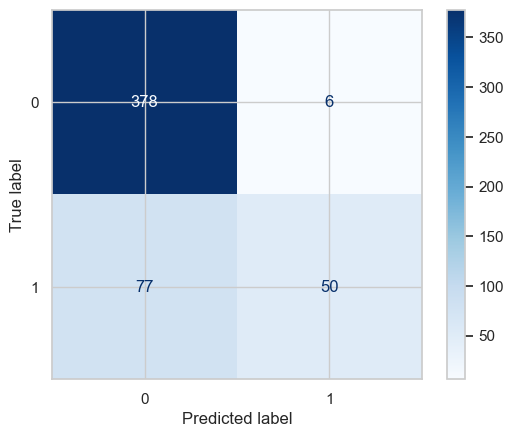

In [47]:
# Generate predictions on the training set
y_pred_train = cH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {cH_RF.score(X_train, y_train):.4f}")

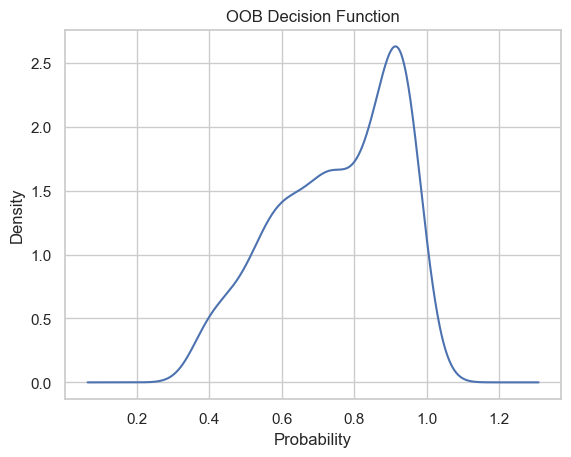

In [48]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.70
xx = pd.DataFrame(cH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [49]:
#determining feature importance
np.argmax(cH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(cH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.233725
energy              0.160292
liveness            0.113386
tempo               0.088704
loudness            0.086658
acousticness        0.069372
duration_ms         0.067519
instrumentalness    0.064373
speechiness         0.061805
key                 0.030016
popularity          0.016413
time_signature      0.005318
mode                0.002255
explicit            0.000165


In [50]:
cHOOB = 1-cH_RF.oob_score_
cHFPR = fpr
cHtpr = tpr
cHpre = precision
cHA = cH_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


## Country Model (-)

In [51]:
# lets separate our X and Y variables for our random forest 
# we will use the valence as our target variable
y = country['valence']
X = country.drop(['valence'], axis = 1)

In [52]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either sad or not sad 
# the cutoff is 0-0.3 and then 0.3-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changecS(valence):
    if valence <= 0.3:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changecS)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [54]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    403
1    108
Name: valence, dtype: int64
0    173
1     47
Name: valence, dtype: int64


In [55]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [56]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6 

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

cS_RF= RFC.fit(X_train,y_train)

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


In [57]:
print('OOB error rate: ' + str(1-cS_RF.oob_score_))

OOB error rate: 0.1428571428571429


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


False Positive Rate: 0.0074
True Positive Rate: 0.4815
Precision: 0.9455
Accuracy: 0.8845


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


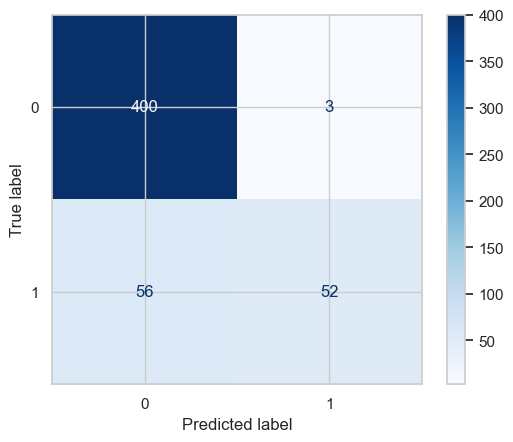

In [58]:
# Generate predictions on the training set
y_pred_train = cS_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cS_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {cS_RF.score(X_train, y_train):.4f}")

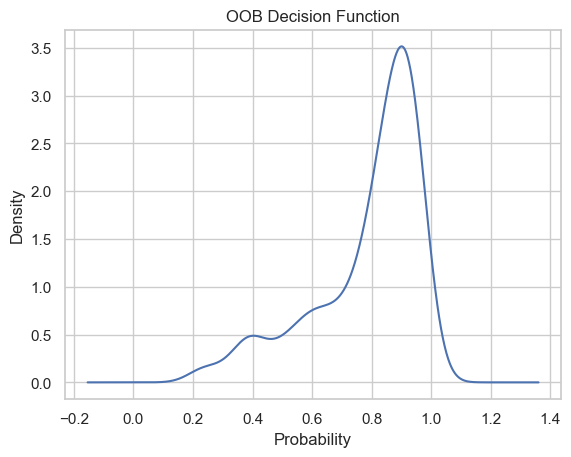

In [59]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.30
xx = pd.DataFrame(cS_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [135]:
#determining feature importance

np.argmax(cS_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(cS_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
energy              0.216509
danceability        0.200895
loudness            0.097872
duration_ms         0.091925
speechiness         0.075127
acousticness        0.073014
liveness            0.071998
instrumentalness    0.057511
tempo               0.051862
key                 0.028211
popularity          0.018229
time_signature      0.012892
mode                0.003509
explicit            0.000447


In [61]:
cSOOB = 1-cS_RF.oob_score_
cSFPR = fpr
cStpr = tpr
cSpre = precision
cSA = cS_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


## Disney Model (+)

In [62]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = disney['valence']
X = disney.drop(['valence'], axis = 1)

In [63]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either happy or not happy 
# the cutoff is 0-0.7 and then 0.7-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changeDH(valence):
    if valence >= 0.7:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changeDH)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [65]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    244
1     36
Name: valence, dtype: int64
0    104
1     16
Name: valence, dtype: int64


In [66]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [67]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

dH_RF= RFC.fit(X_train,y_train)

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


In [68]:
print('OOB error rate: ' + str(1-dH_RF.oob_score_))

OOB error rate: 0.12142857142857144


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.0000
True Positive Rate: 0.0833
Precision: 1.0000
Accuracy: 0.8821


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


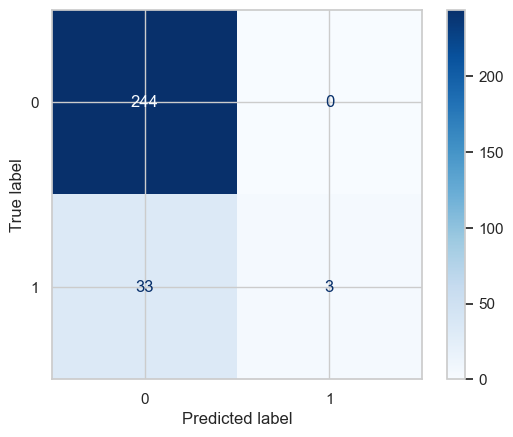

In [69]:
# Generate predictions on the training set
y_pred_train = dH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {dH_RF.score(X_train, y_train):.4f}")

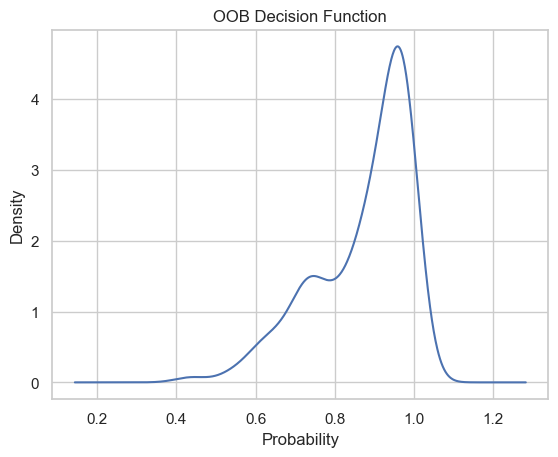

In [70]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.70
xx = pd.DataFrame(dH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [71]:
#determining feature importance
np.argmax(dH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(dH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.240305
energy              0.149947
speechiness         0.104022
instrumentalness    0.095953
acousticness        0.092860
duration_ms         0.070327
loudness            0.070197
liveness            0.054175
tempo               0.050345
popularity          0.038691
key                 0.026572
time_signature      0.004492
mode                0.002113
explicit            0.000000


In [72]:
dHOOB = 1-dH_RF.oob_score_
dHFPR = fpr
dHtpr = tpr
dHpre = precision
dHA = dH_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished


## Disney Model (-)

In [73]:
# lets separate our X and Y variables for our random forest 
# we will use the valence as our target variable
y = disney['valence']
X = disney.drop(['valence'], axis = 1)

In [74]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either sad or not sad 
# the cutoff is 0-0.3 and then 0.3-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changedS(valence):
    if valence <= 0.3:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changedS)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [76]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    141
1    139
Name: valence, dtype: int64
0    61
1    59
Name: valence, dtype: int64


In [77]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [78]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

dS_RF= RFC.fit(X_train,y_train)

# finished in 2.0 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


In [79]:
print('OOB error rate: ' + str(1-dS_RF.oob_score_))

OOB error rate: 0.21785714285714286


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


False Positive Rate: 0.1773
True Positive Rate: 0.8993
Precision: 0.8333


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Accuracy: 0.8607


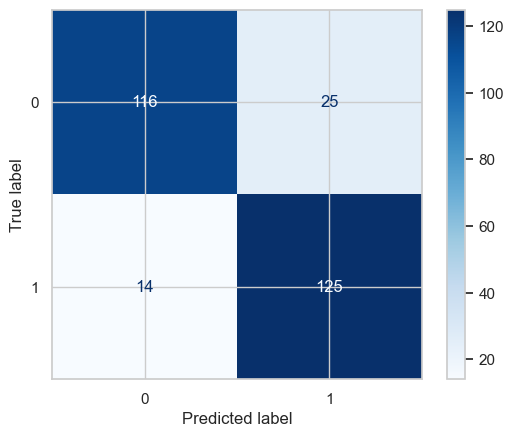

In [80]:
# Generate predictions on the training set
y_pred_train = dS_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dS_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {dS_RF.score(X_train, y_train):.4f}")

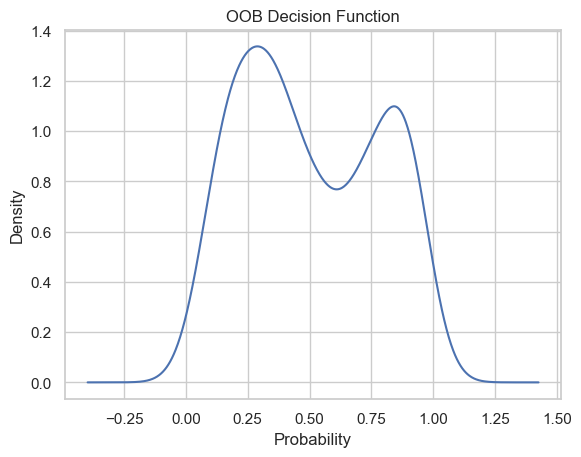

In [81]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.30
xx = pd.DataFrame(dS_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [136]:
#determining feature importance

np.argmax(dS_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(dS_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.205233
energy              0.182114
instrumentalness    0.161766
loudness            0.140158
speechiness         0.093821
acousticness        0.062841
tempo               0.044524
duration_ms         0.034278
liveness            0.025153
popularity          0.021167
key                 0.019782
mode                0.005517
time_signature      0.003646
explicit            0.000000


In [83]:
dSOOB = 1-dS_RF.oob_score_
dSFPR = fpr
dStpr = tpr
dSpre = precision
dSA = dS_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


## Hip Hop Model (+)

In [84]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = hiphop['valence']
X = hiphop.drop(['valence'], axis = 1)

In [85]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either happy or not happy 
# the cutoff is 0-0.7 and then 0.7-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changehhH(valence):
    if valence >= 0.7:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changehhH)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [87]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    357
1    150
Name: valence, dtype: int64
0    153
1     65
Name: valence, dtype: int64


In [88]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [89]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

hhH_RF= RFC.fit(X_train,y_train)

# finished in 1.8 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


In [90]:
print('OOB error rate: ' + str(1-hhH_RF.oob_score_))


OOB error rate: 0.21301775147928992


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.0056
True Positive Rate: 0.4467
Precision: 0.9710
Accuracy: 0.8323


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


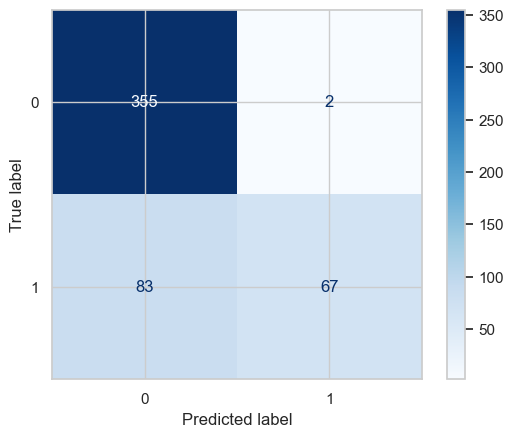

In [91]:
# Generate predictions on the training set
y_pred_train = hhH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hhH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {hhH_RF.score(X_train, y_train):.4f}")

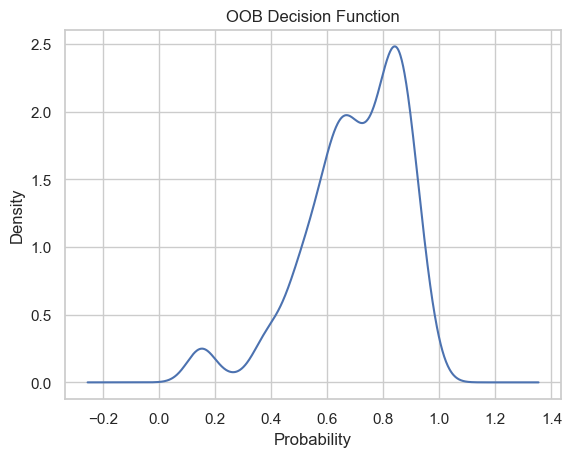

In [92]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.70
xx = pd.DataFrame(hhH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [93]:
#determining feature importance
np.argmax(hhH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(hhH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
energy              0.193441
danceability        0.152768
liveness            0.114108
acousticness        0.094255
duration_ms         0.084639
tempo               0.083242
loudness            0.069501
speechiness         0.064061
popularity          0.046846
key                 0.046555
instrumentalness    0.033770
explicit            0.008399
mode                0.008340
time_signature      0.000073


In [94]:
hhHOOB = 1-hhH_RF.oob_score_
hhHFPR = fpr
hhHtpr = tpr
hhHpre = precision
hhHA = hhH_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


## Hip Hop Model (-)

In [95]:
# lets separate our X and Y variables for our random forest 
# we will use the valence as our target variable
y = hiphop['valence']
X = hiphop.drop(['valence'], axis = 1)

In [96]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either sad or not sad 
# the cutoff is 0-0.3 and then 0.3-1.0

# lets create a function that will change the valence to either 0 or 1
def valence_changehhS(valence):
    if valence <= 0.3:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changehhS)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [98]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    427
1     80
Name: valence, dtype: int64
0    184
1     34
Name: valence, dtype: int64


In [99]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }


In [100]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6 

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

hhS_RF= RFC.fit(X_train,y_train)

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


In [101]:
print('OOB error rate: ' + str(1-hhS_RF.oob_score_))

OOB error rate: 0.1439842209072978


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


False Positive Rate: 0.0000
True Positive Rate: 0.0875
Precision: 1.0000
Accuracy: 0.8560


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


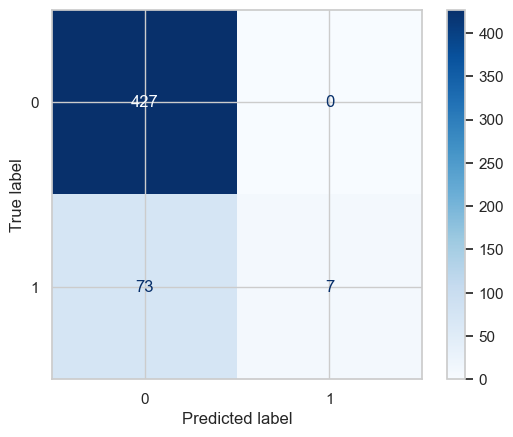

In [102]:
# Generate predictions on the training set
y_pred_train = hhS_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hhS_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {hhS_RF.score(X_train, y_train):.4f}")

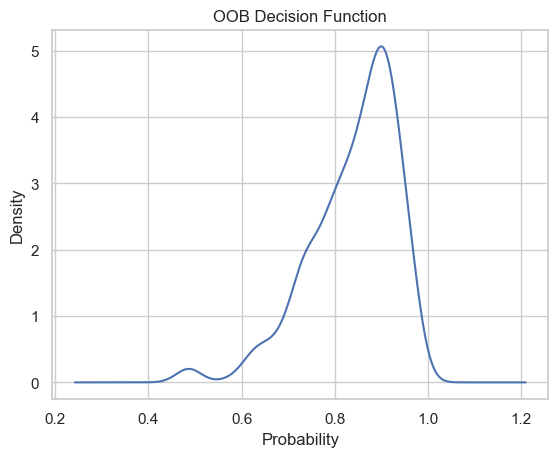

In [103]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.30
xx = pd.DataFrame(hhS_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [137]:
#determining feature importance

np.argmax(hhS_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(hhS_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
acousticness        0.165778
energy              0.132323
danceability        0.119130
tempo               0.087090
speechiness         0.082602
duration_ms         0.082530
loudness            0.070389
liveness            0.062310
key                 0.057859
popularity          0.055509
explicit            0.037351
instrumentalness    0.036523
mode                0.010609
time_signature      0.000000


In [105]:
hhSOOB = 1-hhS_RF.oob_score_
hhSFPR = fpr
hhStpr = tpr
hhSpre = precision
hhSA = hhS_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished


## Pop Model (+)

In [106]:
# lets separate our X and Y variables for our random forest 
# we will use the valence as our target variable
y = pop['valence']
X = pop.drop(['valence'], axis = 1)

In [107]:
# right now valence is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either not happy or happy 
# the cutoff is 0-0.7 and then 0.7-1.0

# lets create a function that will change the danceability to either 0 or 1
def valence_changepH(valence):
    if valence >= 0.7:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changepH)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [109]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    387
1    100
Name: valence, dtype: int64
0    166
1     43
Name: valence, dtype: int64


In [110]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [111]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.7

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

popH_RF= RFC.fit(X_train,y_train)

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


In [112]:
print('OOB error rate: ' + str(1-popH_RF.oob_score_))


OOB error rate: 0.1457905544147844


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.0000
True Positive Rate: 0.3100
Precision: 1.0000
Accuracy: 0.8583


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


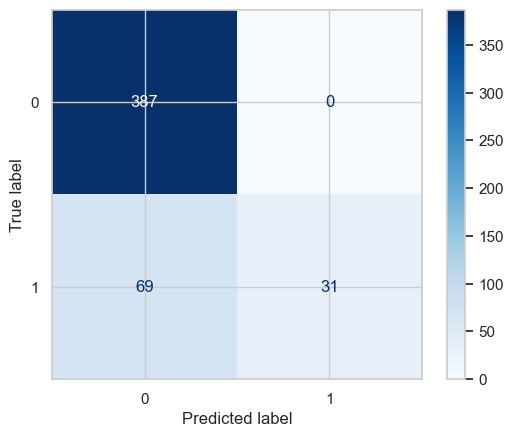

In [113]:
# Generate predictions on the training set
y_pred_train = popH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=popH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {popH_RF.score(X_train, y_train):.4f}")

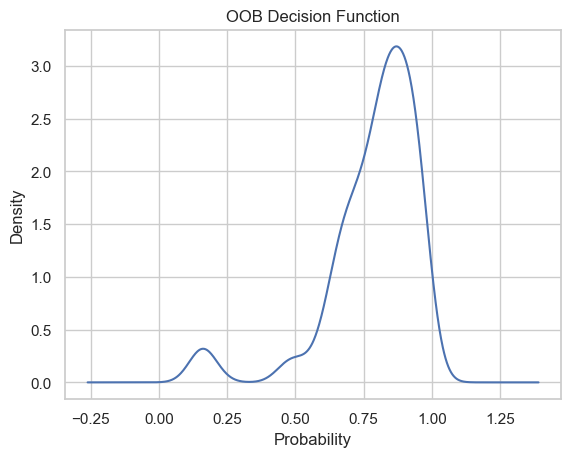

In [114]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.70
xx = pd.DataFrame(popH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()


In [138]:
#determining feature importance

np.argmax(popH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(popH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
liveness            0.186257
energy              0.171296
tempo               0.109730
danceability        0.091869
loudness            0.089693
popularity          0.068621
speechiness         0.067175
acousticness        0.065356
duration_ms         0.063104
key                 0.039910
instrumentalness    0.025857
mode                0.019838
explicit            0.000866
time_signature      0.000428


In [116]:
popHOOB = 1-popH_RF.oob_score_
popHFPR = fpr
popHtpr = tpr
popHpre = precision
popHA = popH_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


## Pop Model (-)

In [117]:
# lets separate our X and Y variables for our random forest 
# we will use the valence as our target variable
y = pop['valence']
X = pop.drop(['valence'], axis = 1)

In [118]:
# right now danceability is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either not danceable or danceable 
# the cutoff is 0-0.3 and then 0.3-1.0

# lets create a function that will change the danceability to either 0 or 1
def valence_changepopS(valence):
    if valence <= 0.3:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changepopS)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [120]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    409
1     78
Name: valence, dtype: int64
0    175
1     34
Name: valence, dtype: int64


In [121]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [122]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6 

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

popS_RF= RFC.fit(X_train,y_train)

# finished in 22 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


In [123]:
print('OOB error rate: ' + str(1-popS_RF.oob_score_))


OOB error rate: 0.1581108829568788


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


False Positive Rate: 0.0049
True Positive Rate: 0.2564
Precision: 0.9091


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Accuracy: 0.8768


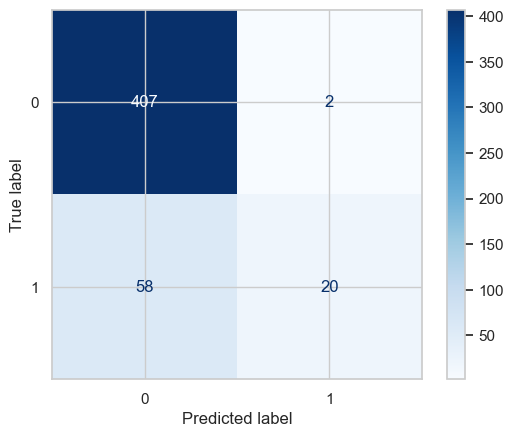

In [124]:
# Generate predictions on the training set
y_pred_train = popS_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
tnr = cm[0,0] / (cm[0,0] + cm[0,1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=popS_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {popS_RF.score(X_train, y_train):.4f}")


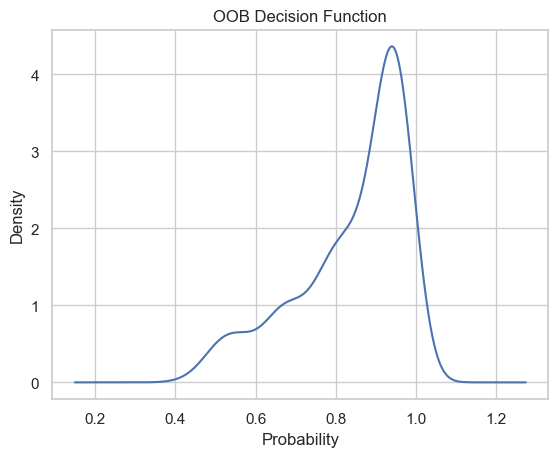

In [125]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.30
xx = pd.DataFrame(popS_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [139]:
#determining feature importance

np.argmax(popS_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(popS_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
energy              0.179857
danceability        0.130611
acousticness        0.124928
loudness            0.113047
instrumentalness    0.087064
speechiness         0.075317
duration_ms         0.070316
popularity          0.060778
liveness            0.052006
tempo               0.044327
key                 0.040701
mode                0.009072
time_signature      0.008576
explicit            0.003400


In [127]:
popSOOB = 1-popS_RF.oob_score_
popSFPR = fpr
popStpr = tpr
popSpre = precision
popSA = popS_RF.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished


### Showing the Data

In [142]:
data = {
    'Genre & Mood': ['Blues (+)', 'Blues (-)', 'Country (+)', 'Country (-)', 'Disney (+)', 'Disney (-)', 'Hip-Hop (+)', 'Hip-Hop (-)', 'Pop (+)', 'Pop (-)'],
    'Accuracy': [bluesA, bluesSA, cHA, cSA,dHA,dSA,hhHA,hhSA,popHA,popSA],
    'OOB Error Rate': [bluesHOOB, bluesSOOB, cHOOB, cSOOB, dHOOB, dSOOB, hhHOOB,hhSOOB,popHOOB,popSOOB],
    'TPR': [bluesHtpr, bluesStpr, cHtpr, cStpr,dHtpr,dStpr, hhHtpr,hhStpr, popHtpr,popStpr],
    'FPR': [bluesHFPR, bluesSFPR, cHFPR,cSFPR,dHFPR,dSFPR,hhHFPR,hhSFPR,popHFPR,popSFPR],
    'Precision': [bluesHpre,bluesSpre, cHpre, cSpre,dHpre,dSpre, hhHpre,hhSpre, popHpre,popSpre]
}

df = pd.DataFrame(data)
print(df)

  Genre & Mood  Accuracy  OOB Error Rate       TPR       FPR  Precision
0    Blues (+)  0.873706        0.207039  0.785714  0.073090   0.866667
1    Blues (-)  0.892340        0.109731  0.103448  0.000000   1.000000
2  Country (+)  0.837573        0.201566  0.393701  0.015625   0.892857
3  Country (-)  0.884540        0.142857  0.481481  0.007444   0.945455
4   Disney (+)  0.882143        0.121429  0.083333  0.000000   1.000000
5   Disney (-)  0.860714        0.217857  0.899281  0.177305   0.833333
6  Hip-Hop (+)  0.832347        0.213018  0.446667  0.005602   0.971014
7  Hip-Hop (-)  0.856016        0.143984  0.087500  0.000000   1.000000
8      Pop (+)  0.858316        0.145791  0.310000  0.000000   1.000000
9      Pop (-)  0.876797        0.158111  0.256410  0.004890   0.909091


In [146]:
data1 = {
    'Genre & Mood': ['Blues (+)', 'Blues (-)', 'Country (+)', 'Country (-)', 'Disney (+)', 'Disney (-)', 'Hip-Hop (+)', 'Hip-Hop (-)', 'Pop (+)', 'Pop (-)'],
    '1': ['Danceability', 'Danceability', 'Danceability', 'Energy','Danceability','Danceability','Energy','Acousticness','Liveness','Energy'],
    '2': ['Duration', 'Energy', 'Energy', 'Danceability', 'Energy', 'Energy','Danceability','Energy','Energy','Danceability'],
    '3': ['Energy', 'Speechiness', 'Liveness','Loudness' ,'Speechiness','Instrumentalness', 'Liveness','Danceability', 'Tempo','Acousticness'],
    '4': ['Speechiness','Acousticness', 'Tempo','Duration','Instrumentalness','Loudness','Acousticness','Tempo','Danceability','Loudness'],
    '5': ['Popularity','Instrumentalness', 'Loudness', 'Speechiness','Acousticness','Speechiness', 'Duration','Speechiness', 'Loudness','Instrumentalness']
}

df1 = pd.DataFrame(data1)
print(df1)

  Genre & Mood             1             2                 3  \
0    Blues (+)  Danceability      Duration            Energy   
1    Blues (-)  Danceability        Energy       Speechiness   
2  Country (+)  Danceability        Energy          Liveness   
3  Country (-)        Energy  Danceability          Loudness   
4   Disney (+)  Danceability        Energy       Speechiness   
5   Disney (-)  Danceability        Energy  Instrumentalness   
6  Hip-Hop (+)        Energy  Danceability          Liveness   
7  Hip-Hop (-)  Acousticness        Energy      Danceability   
8      Pop (+)      Liveness        Energy             Tempo   
9      Pop (-)        Energy  Danceability      Acousticness   

                  4                 5  
0       Speechiness        Popularity  
1      Acousticness  Instrumentalness  
2             Tempo          Loudness  
3          Duration       Speechiness  
4  Instrumentalness      Acousticness  
5          Loudness       Speechiness  
6      Acoustic

In [154]:
data2 = {
    'Genre & Mood': ['Blues (+)', 'Blues (-)', 'Country (+)', 'Country (-)', 'Disney (+)', 'Disney (-)', 'Hip-Hop (+)', 'Hip-Hop (-)', 'Pop (+)', 'Pop (-)'],
    'Precision': [bluesHpre,bluesSpre, cHpre, cSpre,dHpre,dSpre, hhHpre,hhSpre, popHpre,popSpre]
}

df2 = pd.DataFrame(data2)
print(df2)

  Genre & Mood  Precision
0    Blues (+)   0.866667
1    Blues (-)   1.000000
2  Country (+)   0.892857
3  Country (-)   0.945455
4   Disney (+)   1.000000
5   Disney (-)   0.833333
6  Hip-Hop (+)   0.971014
7  Hip-Hop (-)   1.000000
8      Pop (+)   1.000000
9      Pop (-)   0.909091


All Models have high precision which gives confidence that if a song is predicted as positive or negative, its valence is typically positive or negative 

In [144]:
data4 = {
    'Genre & Mood': ['Blues (+)', 'Blues (-)', 'Country (+)', 'Country (-)', 'Disney (+)', 'Disney (-)', 'Hip-Hop (+)', 'Hip-Hop (-)', 'Pop (+)', 'Pop (-)'],
    'Accuracy': [bluesA, bluesSA, cHA, cSA,dHA,dSA,hhHA,hhSA,popHA,popSA],
    'OOB Error Rate': [bluesHOOB, bluesSOOB, cHOOB, cSOOB, dHOOB, dSOOB, hhHOOB,hhSOOB,popHOOB,popSOOB]
}

df4 = pd.DataFrame(data4)
print(df4)

  Genre & Mood  Accuracy  OOB Error Rate
0    Blues (+)  0.873706        0.207039
1    Blues (-)  0.892340        0.109731
2  Country (+)  0.837573        0.201566
3  Country (-)  0.884540        0.142857
4   Disney (+)  0.882143        0.121429
5   Disney (-)  0.860714        0.217857
6  Hip-Hop (+)  0.832347        0.213018
7  Hip-Hop (-)  0.856016        0.143984
8      Pop (+)  0.858316        0.145791
9      Pop (-)  0.876797        0.158111


### How strong are the models at predicting -- TPR and FPR?

In [155]:
## Scale: 
# Positive (TPR)
## - Bad: 0-0.3 | Medium: 0.3 - 0.75 | Good: 0.75 - 1.0
# Not Positive (FPR)
## - Good: 0-0.25

dataH = {
    'Genre': ['Blues', 'Country', 'Disney', 'Hip-Hop', 'Pop'],
    '      Not Positive': ['Good', 'Good', 'Good', 'Good','Good'],
    '      Positive': ['Good', 'Med', 'Bad', 'Med','Med']
}

dfH = pd.DataFrame(dataH)
print(dfH)

     Genre       Not Positive       Positive
0    Blues               Good           Good
1  Country               Good            Med
2   Disney               Good            Bad
3  Hip-Hop               Good            Med
4      Pop               Good            Med


In [153]:
## Scale: 
# Negative (TPR)
## - Bad: 0-0.3 | Medium: 0.3 - 0.75 | Good: 0.75 - 1.0
# Not Negative (FPR)
## - Good: 0-0.25

dataS = {
    'Genre': ['Blues', 'Country', 'Disney', 'Hip-Hop', 'Pop'],
    '      Not Negative': ['Good', 'Good', 'Good', 'Good','Good'],
    '      Negative': ['Bad', 'Med', 'Good', 'Bad','Bad']
}

dfS = pd.DataFrame(dataS)
print(dfS)

     Genre       Not Negative       Negative
0    Blues               Good            Bad
1  Country               Good            Med
2   Disney               Good           Good
3  Hip-Hop               Good            Bad
4      Pop               Good            Bad
